In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [3]:
df = pd.read_excel("eKran.xlsm")
SP = df.loc[df['Estado'] == 'São Paulo']

In [4]:
df.head(3)

,ID do pedido,Data,Empresa,Estado,Vendas,Lucro
0,1,2016-11-08,CG-12520,Bahia,261.96,41.9136
1,2,2016-11-08,CG-12520,Bahia,731.94,219.5820
2,3,2016-06-12,DV-13045,São Paulo,14.62,6.8714


In [4]:
cols = ['ID do pedido', 'Empresa','Estado', 'Lucro']
SP.drop(cols, axis=1, inplace=True)
SP = SP.sort_values('Data')
SP.isnull().sum()

Data      0
Vendas    0
dtype: int64

In [5]:
SP = SP.groupby('Data')['Vendas'].sum().reset_index()

In [6]:
SP = SP.set_index('Data')
SP.index

DatetimeIndex(['2014-01-05', '2014-01-06', '2014-01-13', '2014-01-14',
               '2014-01-16', '2014-01-18', '2014-01-20', '2014-01-27',
               '2014-01-28', '2014-01-31',
               ...
               '2017-12-21', '2017-12-22', '2017-12-23', '2017-12-24',
               '2017-12-25', '2017-12-26', '2017-12-27', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Data', length=983, freq=None)

In [7]:
#Aqui estamos pegando o valor de vendas por mês
y = SP['Vendas'].resample('MS').mean()

In [9]:
y['2017':]

Data
2017-01-01     577.592706
2017-02-01     659.177500
2017-03-01     707.518077
2017-04-01     816.666000
2017-05-01     707.201500
2017-06-01    1053.325152
2017-07-01     941.231960
2017-08-01    1581.699053
2017-09-01    1966.226308
2017-10-01    2035.321000
2017-11-01    1680.097231
2017-12-01    1227.710241
Freq: MS, Name: Vendas, dtype: float64

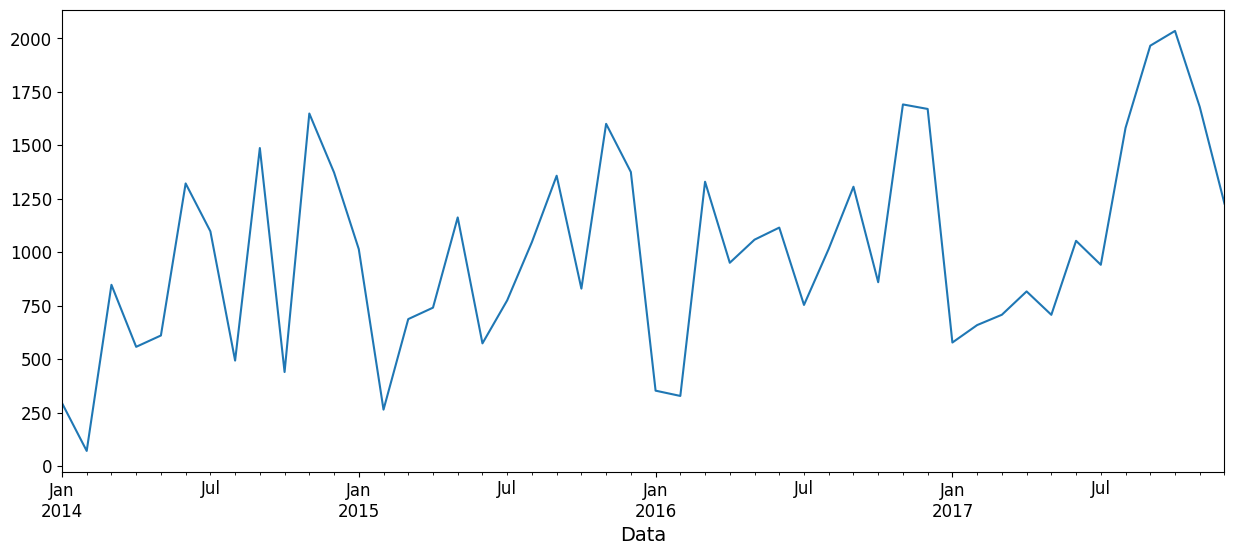

In [31]:
y.plot(figsize=(15,6))
plt.savefig('./ekran/site/public/assets/img/graficos/plot')

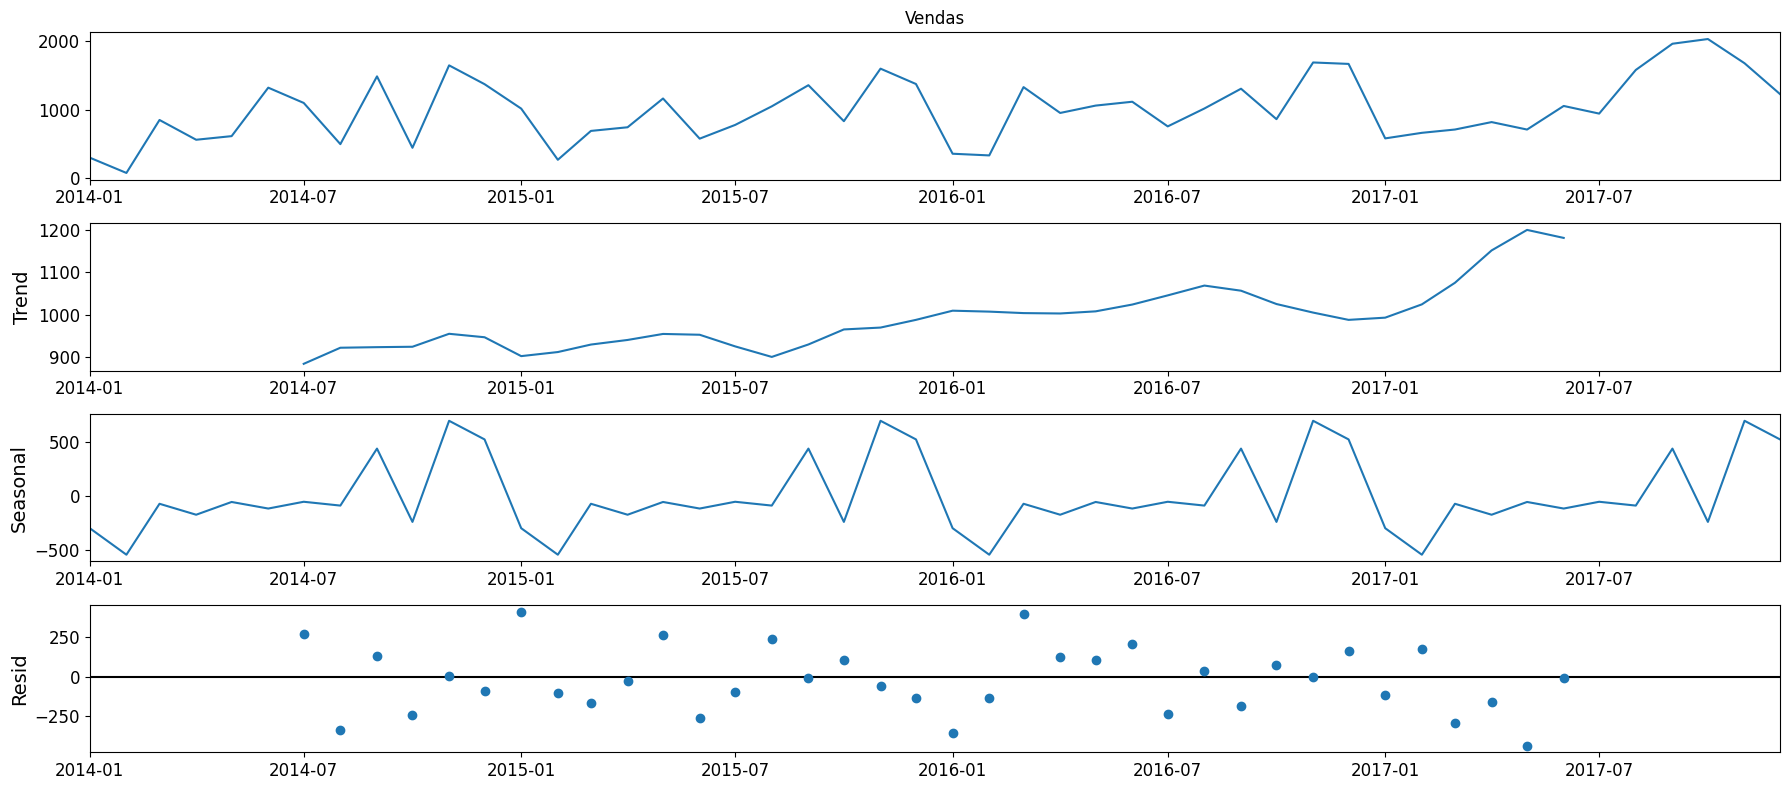

In [22]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
ig = decomposition.plot()
plt.savefig('./ekran/site/public/assets/img/graficos/plot2')


In [35]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Exemplos de parametros sazonais do ARIMA ...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Exemplos de parametros sazonais do ARIMA ...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [10]:
mod = sm.tsa.statespace.SARIMAX(y,
                               order=(1, 1, 1),
                               seasonal_order=(1, 1, 0, 12),
                               enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1094      0.216      0.506      0.613      -0.315       0.534
ma.L1         -1.0000      0.320     -3.124      0.002      -1.627      -0.373
ar.S.L12      -0.5990      0.216     -2.777      0.005      -1.022      -0.176
sigma2      1.199e+05   2.67e-06   4.49e+10      0.000     1.2e+05     1.2e+05


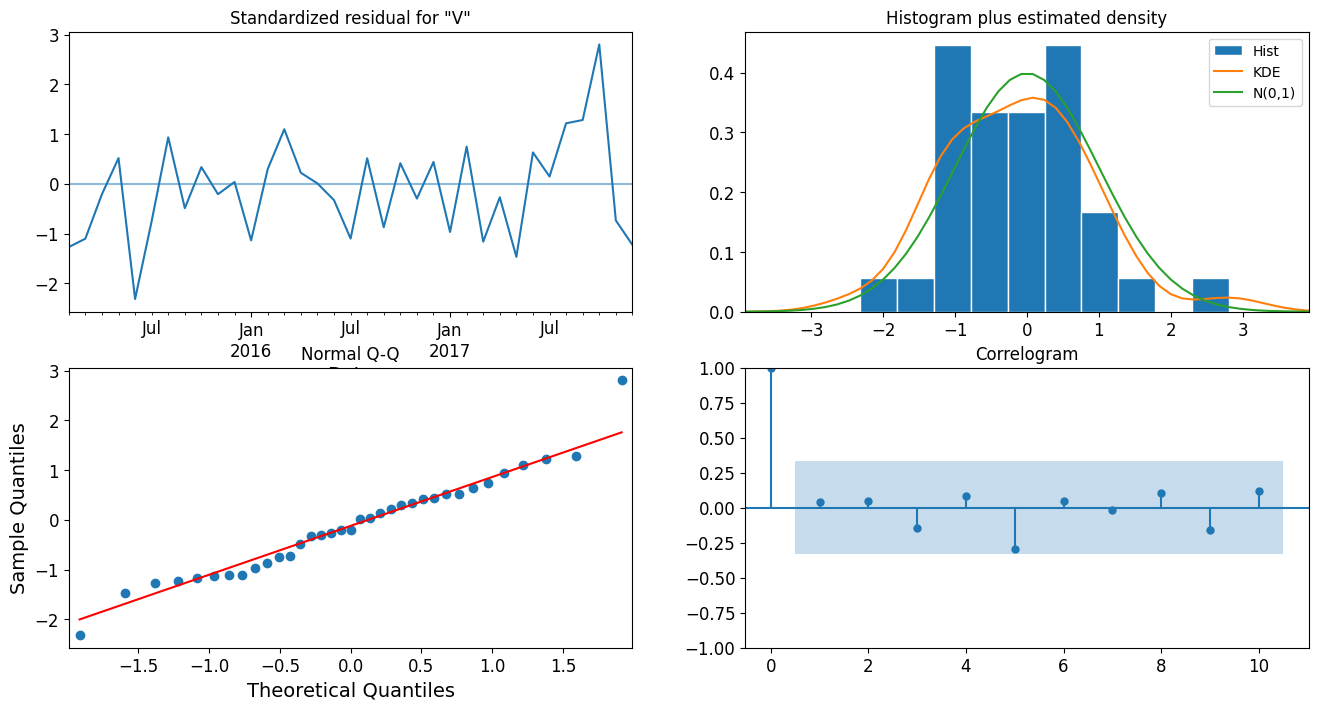

In [25]:
results.plot_diagnostics(figsize=(16, 8))
plt.savefig('./ekran/site/public/assets/img/graficos/plot3')


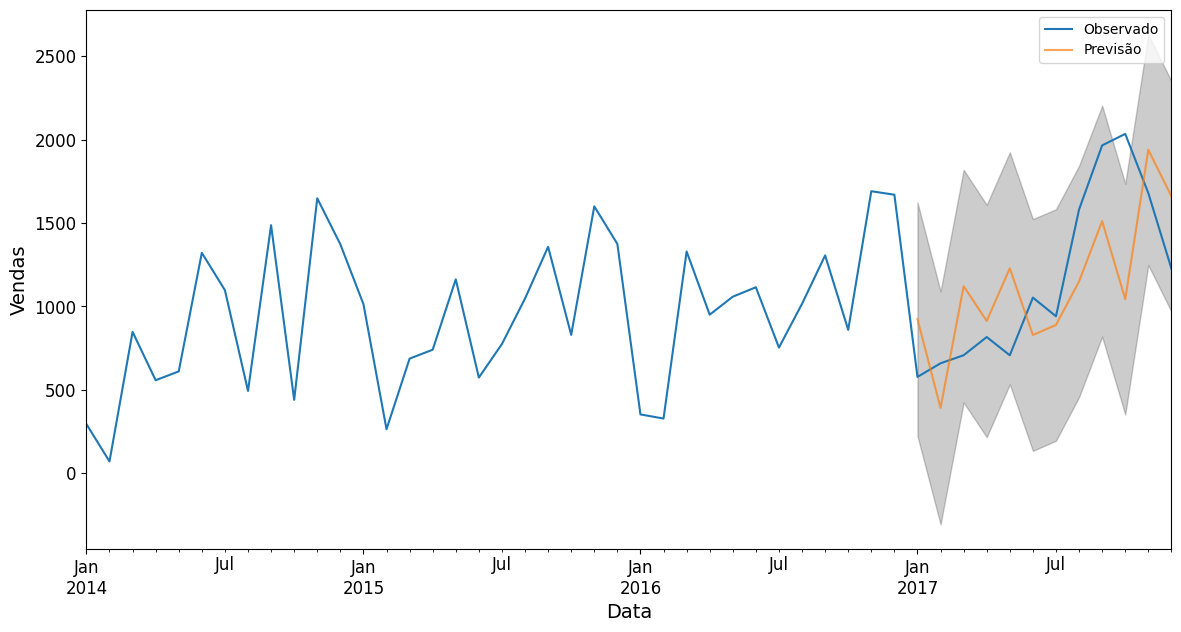

In [26]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci= pred.conf_int()
ax = y['2014':].plot(label='Observado')
pred.predicted_mean.plot(ax=ax, label ='Previsão', alpha=.7, figsize=(14,7))
ax.fill_between(pred_ci.index,
               pred_ci.iloc[:, 0],
               pred_ci.iloc[:,1], color='k', alpha=.2)
ax.set_xlabel('Data')
ax.set_ylabel('Vendas')
plt.legend()
plt.savefig('./ekran/site/public/assets/img/graficos/plot4')


In [40]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth)** 2).mean()
print('The Mean squared error of our forecasts is {}'.format(round(mse, 2)))

The Mean squared error of our forecasts is 194045.57


In [41]:
print('The root mean squared error od ourforecasts is {}'.format(round(np.sqrt(mse), 2)))

The root mean squared error od ourforecasts is 440.51


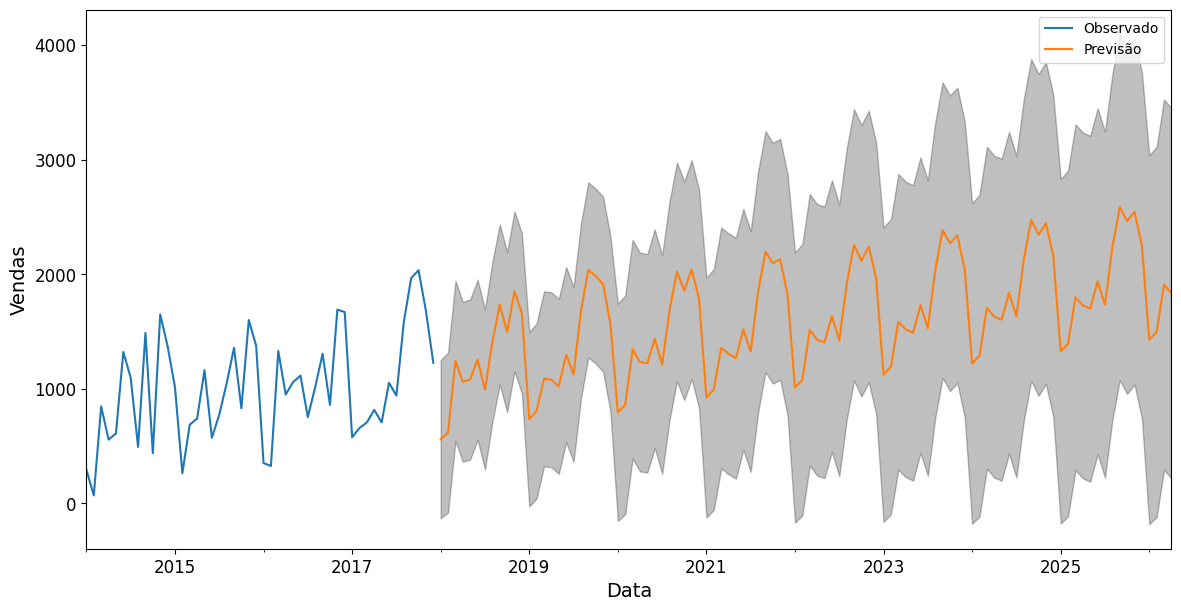

In [28]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='Observado', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Previsão')
ax.fill_between(pred_ci.index,
               pred_ci.iloc[:, 0],
               pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Data')
ax.set_ylabel('Vendas')
plt.legend()
plt.savefig('./ekran/site/public/assets/img/graficos/plot5')


In [14]:
SP = df.loc[df['Estado'] == 'São Paulo']
RJ = df.loc[df['Estado'] == 'Rio de Janeiro']
SP.shape, RJ.shape

((4610, 6), (839, 6))

In [15]:
cols = ['ID do pedido', 'Empresa','Estado', 'Lucro']
SP.drop(cols, axis=1, inplace=True)
SP = SP.sort_values('Data')
SP.isnull().sum()
cols = ['ID do pedido', 'Empresa','Estado', 'Lucro']
RJ.drop(cols, axis=1, inplace=True)
RJ = RJ.sort_values('Data')
RJ.isnull().sum()


Data      0
Vendas    0
dtype: int64

In [16]:
SP = SP.groupby('Data')['Vendas'].sum().reset_index()
RJ = RJ.groupby('Data')['Vendas'].sum().reset_index()

In [17]:
SP = SP.set_index('Data')
SP.index
RJ = RJ.set_index('Data')
RJ.index

DatetimeIndex(['2014-01-10', '2014-01-11', '2014-01-21', '2014-01-26',
               '2014-02-02', '2014-02-06', '2014-02-11', '2014-03-04',
               '2014-03-14', '2014-03-15',
               ...
               '2017-11-30', '2017-12-02', '2017-12-03', '2017-12-07',
               '2017-12-08', '2017-12-10', '2017-12-11', '2017-12-17',
               '2017-12-22', '2017-12-25'],
              dtype='datetime64[ns]', name='Data', length=361, freq=None)

In [18]:
y_SP = SP['Vendas'].resample('MS').mean()
y_RJ = RJ['Vendas'].resample('MS').mean()
SP = pd.DataFrame({'Data': y_SP.index, 'Vendas':y_SP.values})
RJ = pd.DataFrame({'Data': y_RJ.index, 'Vendas':y_RJ.values})
store = SP.merge(RJ, how='inner', on='Data')
store.rename(columns={'Vendas_x': 'SP_Vendas', 'Vendas_y': 'RJ_Vendas'}, inplace=True)
store.head()

,Data,SP_Vendas,RJ_Vendas
0,2014-01-01,294.628300,258.657000
1,2014-02-01,70.518750,676.328667
2,2014-03-01,847.606500,3432.922889
3,2014-04-01,557.479842,893.983333
4,2014-05-01,610.535118,623.413333


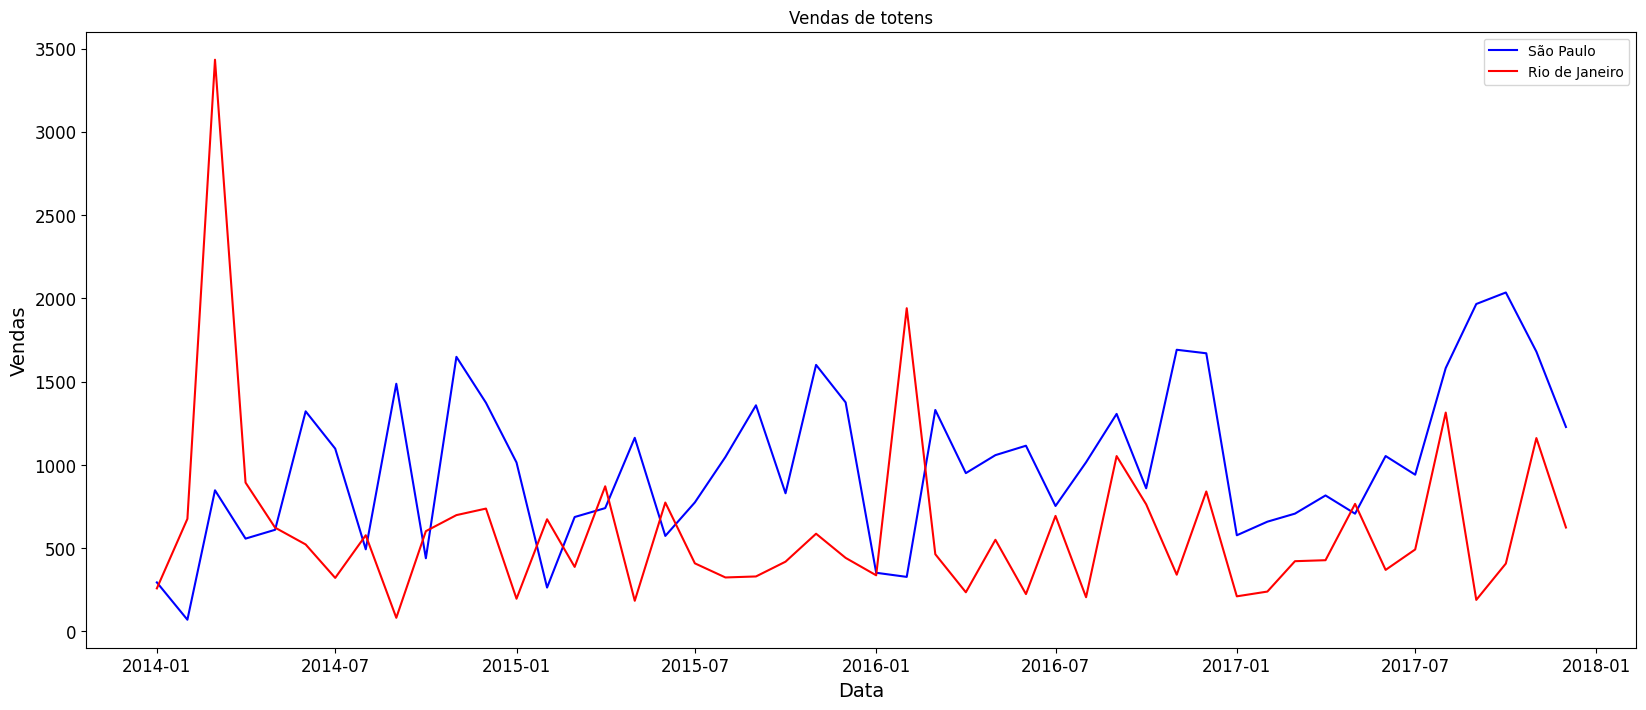

In [30]:
plt.figure(figsize=(20, 8))
plt.plot(store['Data'], store['SP_Vendas'],'b-', label = 'São Paulo')
plt.plot(store['Data'], store['RJ_Vendas'], 'r-', label = 'Rio de Janeiro')
plt.xlabel('Data'); plt.ylabel('Vendas'); plt.title('Vendas de totens')
plt.legend()
plt.savefig('./ekran/site/public/assets/img/graficos/plot6')